여러 확률변수의 결합분포를 구해야 하는 경우를 생각하자. 

예를 들어 A, B, C, 3개의 확률변수가 있고 각 확률변수가 0, 1, 2 세가지의 값만 가질 수 있는 카테고리 확률변수인 경우 이 세 확률변수의 결합분포는 다음과 같이 표로 나타낼 수 있다. 이 표는  3^3−1=26 개의 모수를 가지므로 (합이 1이 되어야 하므로 하나는 다른 값들에 의존한다.) 이 표를 저장하라면 26개의 저장 공간이 필요하다.

## 베이지안 네트워크 모형

그런데 현실에서는 모든 확률변수가 서로 영향을 미치는 복잡한 경우 보다 특정한 몇개의 확률분포들이 서로 영향을 미친다. 예를 들어 A, B, C가 각각 어떤 학생의

+ A: 건강 상태
+ B: 공부 시간
+ C: 시험 성적

을 나타낸 것이라고 하자. 이 확률변수는 각각  {0,1,2} 라는 값을 가질 수 있는데 하(0), 중(1), 상(2)의 상태를 나타낸다. 즉  𝐴=0 이면 건강 상태가 안좋은 것이고  𝐵=1 이면 공부 시간이 보통이며  𝐶=2 이면 시험 성적이 좋은 것이다.

공부시간  𝐵 는 시험 성적  𝐶 에 영향을 미친다. 하지만 건강 상태  𝐴 는 공부 시간  𝐵 와 인과 관계가 있지만 시험 성적  𝐶 와는 직접적인 인과 관계가 없다. 

#### 이렇게 다수의 확률변수 중 특정한 소수의 확률변수들이 가지는 관계를 그래프로 표현한 것을 그래프 확률모형(graphical probability model)이라고 하고,

#### 그래프 확률모형 중에서도 이렇게 인과관계가 확실하여 방향성 그래프로 표시할 수 있는 것을 베이지안 네트워크 모형이라고 한다. 

위의 확률변수를 베이지안 네트워크 모형으로 그리면 다음과 같다.

In [8]:
import networkx as nx
from IPython.core.display import Image
from networkx.drawing.nx_pydot import to_pydot

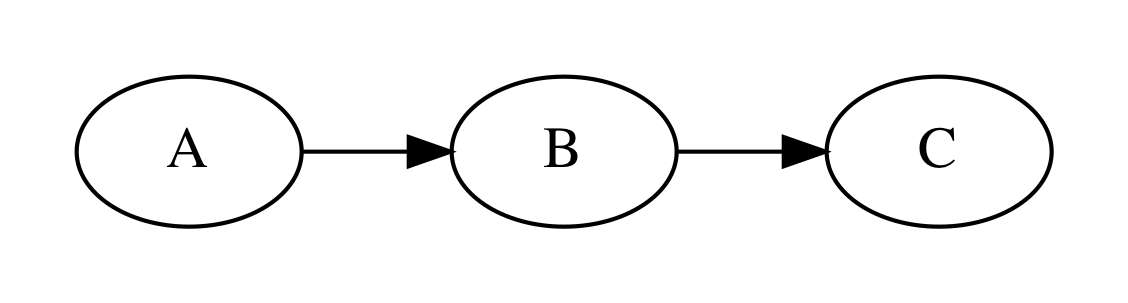

In [9]:
g1 = nx.DiGraph()
g1.add_path(["A", "B", "C"])
d1 = to_pydot(g1)
d1.set_dpi(300)
d1.set_rankdir("LR")
d1.set_margin(0.2)
Image(d1.create_png(), width=600)

이러한 그래프를 방향성 그래프(directed graph)라고 한다. 방향성 그래프에서 확률변수는 하나의 노드(node) 또는 정점(vertex)로 나타내고 인과관계는 화살표 간선(edge, link)으로 나타낸다. 우리가 다루는 방향성 그래프는 화살표가 여러 확률변수를 거쳐 자기 자신에게 돌아오는 루프(loop)가 없는 DAG(Directed Acyclic Graph)모형이다.

방향성 그래프 모델에서는 원인과 결과가 되는 두 확률변수의 관계를 조건부 확률분포로 표현한다. 위의 모형에서처럼 A가 B의 원인이 된다면 이 두 확률변수의 관계를  𝑃(𝐵|𝐴) 로 나타내고 B가 C의 원인이 되므로 두 확률변수의 관계는  𝑃(𝐶|𝐵) 로 나타낸다.

그리고 전체 확률변수들간의 관계는 이러한 조건부 확률분포를 결합하여 나타낼 수 있다. 위의 그래프에서 전체 결합분포는 다음과 같다.

$$P(A, B, C) = P(A)P(B|A)P(C|B)$$

#### 단, 여기에서 유의해야 점은 A와 C는 직접적인 인과 관계가 없지만 상관관계는 있을 수 있다는 점이다. 

예를 들어 A-B, B-C간의 관계가 모두 양의 상관관계이면 A가 커졌을 때 B도 커지고 따라서 C도 커지므로 A와 C가 양의 상관관계를 가지게 된다. A, B, C가 의미하는 바로 해석하면 건강 상태와 시험 성적은 직접적인 인과관계는 없지만 건강 상태가 좋을 때 공부 시간도 많아질 가능성이 높고 공부 시간이 많을 때 시험 성적이 좋아진다면 건강 상태와 시험 성적은 양의 상관관계를 가질 수 있다.

조건부확률분포를 표로 나타내면 다음과 같다.

이 경우에 우리가 알아야 하는 모수의 수는

+ 𝑃(𝐴) :  3−1=2 
+ 𝑃(𝐵|𝐴) :  (3-1)×3=6 
+ 𝑃(𝐶|𝐵) :  (3-1)×3=6 

따라서 총  14 개이다. 변수간의 인과 관계라는 추가 정보로 인해 모수의 숫자가  26 개에서  14 개로 크게 감소하였다. 이렇게 우리가 알고 있는 확률변수간의 정보를 그래프를 이용하여 추가하면 문제를 더 간단하게 만들 수 있다.

pgmpy 패키지에서는 TabularCPD 클래스로 조건부확률분포를 구현할 수 있다. 위 예제의 조건부확률분포  𝑃(𝐴),𝑃(𝐵|𝐴),𝑃(𝐶|𝐵) 를 파이썬으로 구현해 보자. 우선 건강 상태는 나쁠(A=0) 확률이 10%, 보통(A=1)일 확률이 60%, 좋을 확률이 30%라고 하자.

In [10]:
from pgmpy.factors.discrete import TabularCPD

In [11]:
P_A = TabularCPD('A', 3, [[0.1, 0.6, 0.3]])

In [12]:
print(P_A)

+------+-----+
| A(0) | 0.1 |
+------+-----+
| A(1) | 0.6 |
+------+-----+
| A(2) | 0.3 |
+------+-----+


건강 상태 조건 A에 따른 공부시간 B의 확률분포는 다음과 같다.

+ 건강 상태가 나쁘면(A=0), 공부시간이 적거나(B=0), 보통이거나(B=1), 많을(B=2) 확률은 각각 60%, 30%, 10%다.
+ 건강 상태가 보통이면(A=1), 공부시간이 적거나(B=0), 보통이거나(B=1), 많을(B=2) 확률은 각각 30%, 50%, 20%다.
+ 건강 상태가 좋으면(A=2), 공부시간이 적거나(B=0), 보통이거나(B=1), 많을(B=2) 확률은 각각 10%, 30%, 60%다.

확률분포값 행렬의 모양에 주의하라. 같은 조건의 확률은 같은 행이 아닌 같은 열에 들어간다.

In [13]:
import numpy as np

P_B_I_A = TabularCPD('B', 3, np.array([[0.6, 0.2, 0.2], [0.3, 0.5, 0.2], [0.1, 0.3, 0.6]]), evidence=['A'], evidence_card=[3])
print(P_B_I_A)

+------+------+------+------+
| A    | A(0) | A(1) | A(2) |
+------+------+------+------+
| B(0) | 0.6  | 0.2  | 0.2  |
+------+------+------+------+
| B(1) | 0.3  | 0.5  | 0.2  |
+------+------+------+------+
| B(2) | 0.1  | 0.3  | 0.6  |
+------+------+------+------+


CPD 객체는 marginalize 메서드로 특정 변수의 모든 경우의 확률을 더하는 sum-out을 할 수 있다.

$$P(B) = \sum_A P(A,B) = \sum_A P(B|A)P(A)$$

In [14]:
print(P_B_I_A * P_A)  

+------+----------------------+------+------+
| A    | A(0)                 | A(1) | A(2) |
+------+----------------------+------+------+
| B(0) | 0.06                 | 0.12 | 0.06 |
+------+----------------------+------+------+
| B(1) | 0.03                 | 0.3  | 0.06 |
+------+----------------------+------+------+
| B(2) | 0.010000000000000002 | 0.18 | 0.18 |
+------+----------------------+------+------+


In [15]:
P_B = (P_B_I_A * P_A).marginalize(["A"], inplace=False)
print(P_B)

+------+------+
| B(0) | 0.24 |
+------+------+
| B(1) | 0.39 |
+------+------+
| B(2) | 0.37 |
+------+------+


공부시간 B에 따른 성적 C의 확률분포는 다음과 같다.

+ 공부시간이 적으면(B=0), 성적이 나쁘거나(C=0), 보통이거나(C=1), 좋을(C=2) 확률은 각각 80%, 10%, 10%이다.
+ 공부시간이 보통이면(B=1), 성적이 나쁘거나(C=0), 보통이거나(C=1), 좋을(C=2) 확률은 각각 10%, 80%, 10%이다.
+ 공부시간이 많으면(B=2), 성적이 나쁘거나(C=0), 보통이거나(C=1), 좋을(C=2) 확률은 각각 10%, 10%, 80%이다.

In [16]:
P_C_I_B = TabularCPD('C', 3, np.array([[0.8, 0.1, 0.1], [0.1, 0.8, 0.1], [0.1, 0.1, 0.8]]), evidence=['B'], evidence_card=[3])
print(P_C_I_B)

+------+------+------+------+
| B    | B(0) | B(1) | B(2) |
+------+------+------+------+
| C(0) | 0.8  | 0.1  | 0.1  |
+------+------+------+------+
| C(1) | 0.1  | 0.8  | 0.1  |
+------+------+------+------+
| C(2) | 0.1  | 0.1  | 0.8  |
+------+------+------+------+


마찬가지로 B를 marginalize하여 없애면 C에 대한 확률만 남는다.

In [17]:
P_C = (P_C_I_B * P_B).marginalize(["B"], inplace=False)
print(P_C)

+------+-------+
| C(0) | 0.268 |
+------+-------+
| C(1) | 0.373 |
+------+-------+
| C(2) | 0.359 |
+------+-------+


이 조건부 확률들을 결합하여 하나의 베이지안 네트워크로 만들려면 BayesianModel 클래스를 사용한다. 생성자에는 노드를 연결한 그래프 정보를 넣고 add_cpds 메서드로 조건부확률을 추가할 수 있다.

In [18]:
from pgmpy.models import BayesianModel

model = BayesianModel([('A', 'B'), ('B', 'C')])  # 노드를 연결한 그래프 정보 넣기
model.add_cpds(P_A, P_B_I_A, P_C_I_B)
model.check_model()

True

클래스 객체를 graphviz와 pydot 패키지로 시각화할 수도 있다.

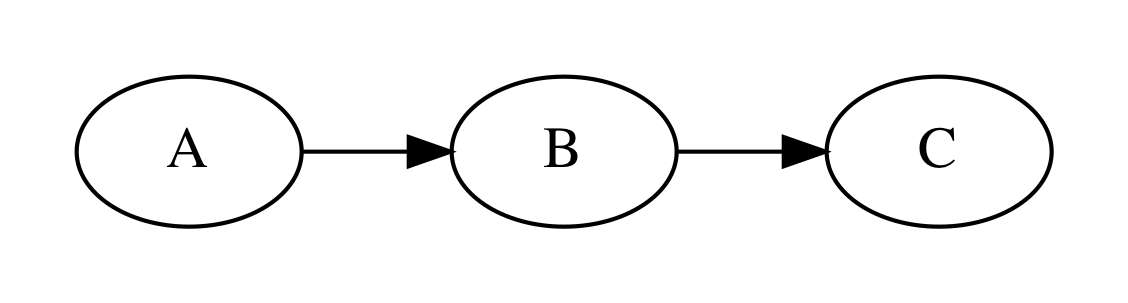

In [19]:
from IPython.core.display import Image
from networkx.drawing.nx_pydot import to_pydot

d = to_pydot(model)
d.set_dpi(300)
d.set_margin(0.2)
d.set_rankdir('LR')
Image(d.create_png(), width=600)

이렇게 만들어진 모형으로부터 여러가지 추론(inference)을 할 수 있다. 예를 들어 전체 결합확률분포 함수를 찾고 그 함수로부터 A, B, C의 marginal 확률분포를 계산하면 A, B, C의 값으로 어떤 값이 가장 확률이 높은지 알 수 있다. 분석 결과를 보면 시험 성적이 좋을 확률은 35.9%이다. 추론에 사용된 VariableElimination 클래스의 사용법에 대해서는 곧 학습한다.

In [22]:
from pgmpy.inference import VariableElimination
inference = VariableElimination(model)
result = inference.query(variables=["C"])
print(result)

Eliminating: A: 100%|██████████| 2/2 [00:00<00:00, 253.42it/s]

+------+----------+
| C    |   phi(C) |
+======+==========+
| C(0) |   0.2680 |
+------+----------+
| C(1) |   0.3730 |
+------+----------+
| C(2) |   0.3590 |
+------+----------+


In [23]:
result1 = inference.query(variables=["A"])
print(result1)

Eliminating: C: 100%|██████████| 2/2 [00:00<00:00, 419.18it/s]

+------+----------+
| A    |   phi(A) |
+======+==========+
| A(0) |   0.1000 |
+------+----------+
| A(1) |   0.6000 |
+------+----------+
| A(2) |   0.3000 |
+------+----------+


In [24]:
result2 = inference.query(variables=["B"])
print(result2)

Eliminating: C: 100%|██████████| 2/2 [00:00<00:00, 356.57it/s]

+------+----------+
| B    |   phi(B) |
+======+==========+
| B(0) |   0.2400 |
+------+----------+
| B(1) |   0.3900 |
+------+----------+
| B(2) |   0.3700 |
+------+----------+


## 베이지안 네트워크의 결합확률분포

베이지안 네트워크를 만들려면 조사 대상이 되는 확률변수를 노드(node)로 생성하고 인과관계가 있는 노드를 방향성 간선(directed edge)으로 연결한다. 베이지안 네트워크를 구성하는 확률변수의 결합확률분포는 다음과 같이 주어진다.

$$P(X_1, \cdots, X_N) = \prod_{i=1}^N P(X_i | Pa(X_i))$$

이 식에서  𝑃𝑎(𝑋𝑖) 는  𝑋𝑖 의 부모 노드이다.

In [25]:
g1 = nx.DiGraph()
edges = [("X1", "X3"), ("X1", "X4"), ("X3", "X4"), ("X2", "X4"), ("X2", "X7"), ("X4", "X5"), ("X4", "X6")]
for edge in edges:
    g1.add_edge(*edge)

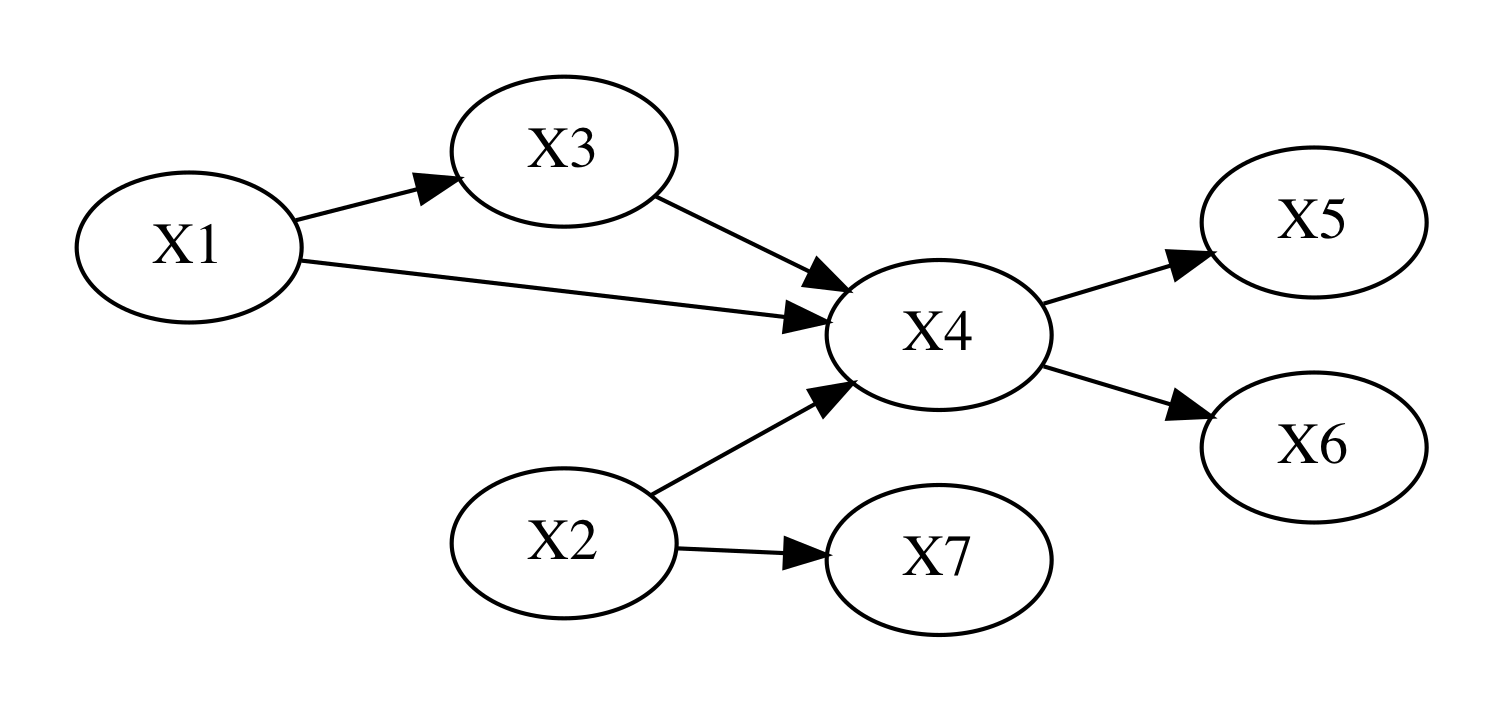

In [26]:
d1 = to_pydot(g1)
d1.set_dpi(300)
d1.set_margin(0.2)
d1.set_rankdir("LR")
Image(d1.create_png(), width=800)

예를 들어  𝑋1,…,𝑋6 의 관계가 앞 그래프와 같다면 결합확률분포는 다음과 같다.

$$P(X_1, X_2, X_3, X_4, X_5, X_6, X_7) = P(X_1) P(X_2) P(X_3 | X_1) P(X_4| X_1, X_2, X_3) P(X_5|X_4) P(X_6|X_4) P(X_7|X_2)$$

## 조건부 독립

베이지안 네트워크를 만들 때 중요한 것은 확률변수간의 조건부 독립 관계가 그래프에 나타나고 있어야 한다는 점이다.

조건부 독립(conditional independence)은 일반적인 독립과 달리 조건이 되는 확률변수가 존재해야 한다.

일반적으로는 확률변수 A, B가 독립인 정의는 다음과 같다.

$$P(A, B) = P(A)P(B)$$

조건부 독립은 조건이 되는 C라는 확률변수에 대한 조건부 결합확률분포에 대해 다음이 만족되어야 한다.

$$P(A, B|C) = P(A|C) P(B|C)$$

즉, C에 대한 조건부 결합확률분포가 조건부 확률분포의 곱으로 나타난다.

기호로는 다음과 같이 표기한다.

$$A \text{⫫} B \;\vert\; C$$

같은 방식으로 무조건부 독립은 다음과 같이 표기하도 한다.

$$A \text{⫫} B \;\vert\; \emptyset$$

A, B가 C에 대해 조건부 독립이면 다음도 만족한다.

$$P(A|B,C) = P(A|C)$$

$$P(B|A,C) = P(B|C)$$

주의할 점은 조건부 독립과 (무조건부) 독립은 관계가 없다는 점이다. 즉, 두 확률변수가 독립이라고 항상 조건부 독립이 되는 것도 아니고 조건부 독립이라고 꼭 독립이 되는 것도 아니다.

$$P(A,B) = P(A)P(B) \;\; \bcancel{\implies} \;\; P(A,B|C) = P(A|C)P(B|C)$$

$$P(A,B|C) = P(A|C)P(B|C) \;\; \bcancel{\implies} \;\; P(A,B) = P(A)P(B)$$

## 방향성 분리

방향성 분리(d-separation, directed separation) 정리는 방향성 그래프 모형에서 어떤 두 노드(확률변수)가 조건부 독립인지 아닌지 알아보는 방법이다. 다음과 같은 세가지 간선 결합을 알아야 한다.

+ 꼬리-꼬리 결합
+ 머리-꼬리 결합
+ 머리-머리 결합

### 1. 꼬리-꼬리 결합

우선 다음과 같이 확률변수 A, B가 공통의 부모 C를 가지는 경우를 보자. C에서는 간선(화살표)의 꼬리가 2개 붙어 있기 때문에 C는 꼬리-꼬리(tail-to-tail ) 결합이라고 한다.

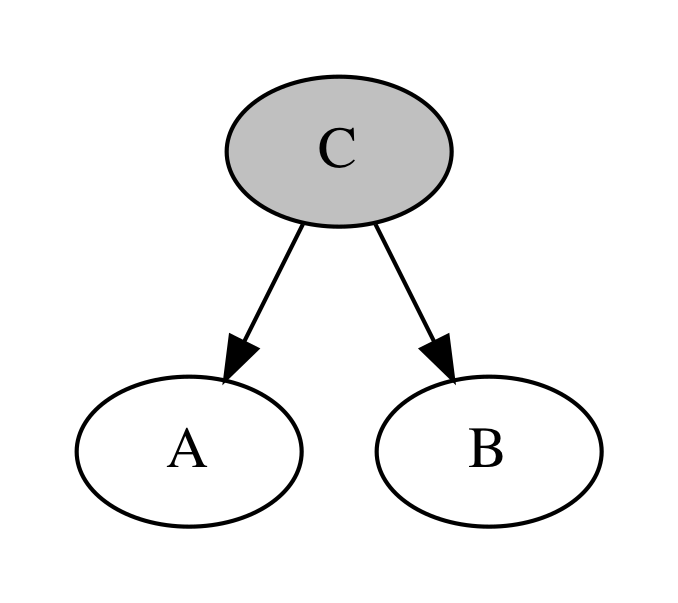

In [27]:
g2 = nx.DiGraph()
g2.add_path(["C", "A"])
g2.add_path(["C", "B"])
d2 = to_pydot(g2)
d2.get_node("C")[0].set_fillcolor("gray")
d2.get_node("C")[0].set_style("filled")
d2.set_dpi(300)
d2.set_margin(0.2)
Image(d2.create_png(), width=400)

이 때 A와 B는 독립은 아니지만 조건부 독립이 성립한다.

$$P(A,B|C) = \dfrac{P(A, B, C)}{P(C)} = \dfrac{P(A|C)P(B|C)P(C)}{P(C)} = P(A|C)P(B|C)$$

즉 C가 어떤 값인지 알고 있을 때 A의 확률은 B의 값과 아무런 관계가 없다.

### 2. 머리-꼬리 결합

다음으로는 인과관계인 확률변수 A, B 사이에 C가 끼어 있는 경우를 살펴보자. 이때 노드 C에서 간선의 머리와 꼬리가 만나기 때문에 머리-꼬리(head-to-tail ) 결합이라고 한다.



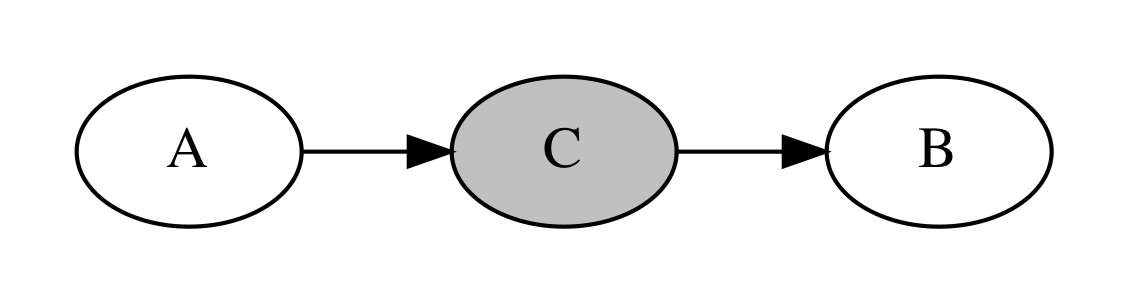

In [29]:
g3 = nx.DiGraph()
g3.add_path(["A", "C", "B"])
d3 = to_pydot(g3)
d3.set_dpi(300)
d3.get_node("C")[0].set_fillcolor("gray")
d3.get_node("C")[0].set_style("filled")
d3.set_rankdir("LR")
d3.set_margin(0.2)
Image(d3.create_png(), width=600)

이 경우에도 A와 B는 독립이 아니지만 조건부 독립이 성립한다.

$$P(A,B|C) = \dfrac{P(A, B, C)}{P(C)} = \dfrac{P(A)P(C|A)P(B|C)}{P(C)} = \dfrac{P(A,C)P(B|C)}{P(C)} = P(A|C)P(B|C)$$

즉 C가 어떤 값인지 알고 있을 때 A의 확률은 B의 값과 아무런 관계가 없다.


### 3. 머리-머리 결합

마지막으로 두 확률변수 A, B 를 부모로 가지는 C가 있는 경우를 살펴보자. 이러한 구조는 V-구조(V-structure) 또는 머리-머리(head-to-head) 결합이라고 한다.

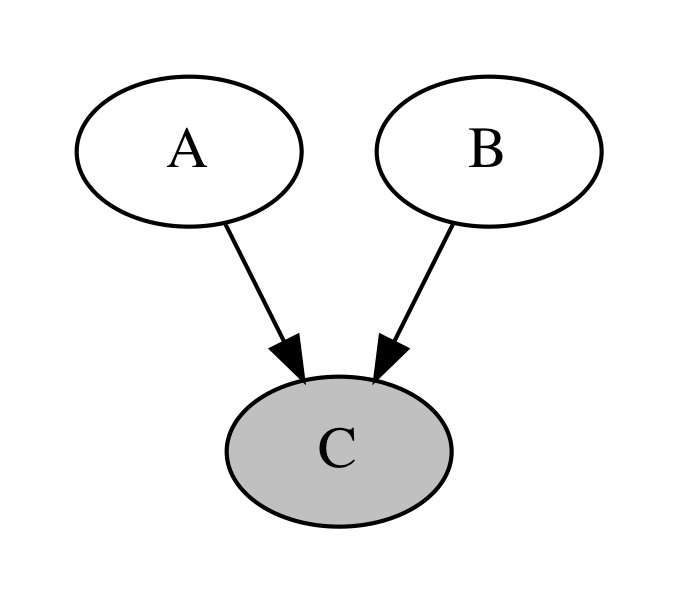

In [30]:
g4 = nx.DiGraph()
g4.add_path(["A", "C"])
g4.add_path(["B", "C"])
d4 = to_pydot(g4)
d4.get_node("C")[0].set_fillcolor("gray")
d4.get_node("C")[0].set_style("filled")
d4.set_dpi(300)
d4.set_margin(0.2)
Image(d4.create_png(), width=600)

이 경우에는 앞의 두 경우와 달리 A와 B가 독립이다.

$$P(A,B,C) = P(A)P(B)P(C|A,B)$$

$$P(A,B) = \sum_c P(A)P(B)P(C|A,B) = P(A)P(B)$$

하지만 조건부 독립은 성립하지 않는다. 즉 C값을 알고 있다면 A와 B가 서로 종속관계가 된다.

예를 들어 A가 늦잠을 자는 것을 나타내는 확률변수, B가 길이 막히는 것을 나타내는 확률변수, C가 지각하는 것을 나타내는 확률변수라고 할 때, 늦잠을 자는 것과 길이 막히는 것은 서로 독립이다.

하지만 일단 지각(C)이 발생한 상황에서는 A, B는 서로 독립이 아니며 이 경우에는 반-상관관계를 가진다. 즉, 늦잠을 자지 않았다면 길이 막혔을 가능성이 높아지고 길이 막히지 않았다면 늦잠을 잤을 가능성이 높아진다. 이러한 것을 explaining-out이라고 한다.

이러한 상황은 C가 A, B의 직접적 자식이 아니라 후손(descendent)인 경우에도 성립한다.

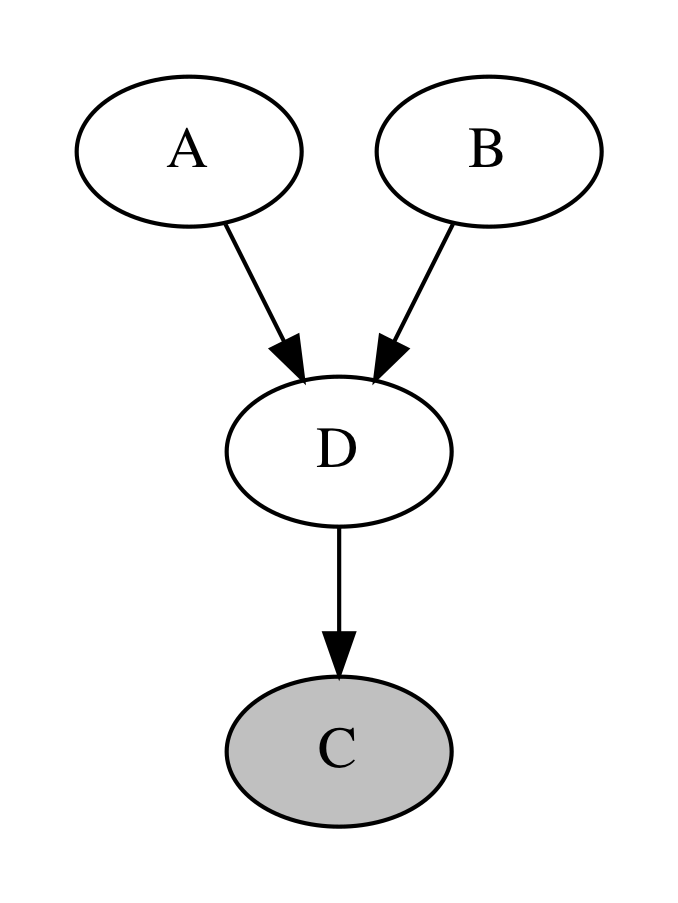

In [33]:
g5 = nx.DiGraph()
g5.add_path(["A", "D"])
g5.add_path(["B", "D"])
g5.add_path(["D", "C"])
d5 = to_pydot(g5)
d5.get_node("C")[0].set_fillcolor("gray")
d5.get_node("C")[0].set_style("filled")
d5.set_dpi(300)
d5.set_margin(0.2)
Image(d5.create_png(), width=400)

이상의 상황을 정리한 것이 바로 방향성 분리(d-separation) 정리이다. 방향성 분리(d-separation) 정리에 따르면 A와 B가 C에 대해서 조건부 독립인 경우는 다음 조건이 만족되어야 한다.

(1) C가 A, B 사이의 경로에 있는 꼬리-꼬리 결합이거나 머리-꼬리 결합이다.

(2) C가 A, B 사이의 경로상에 있는 머리-머리 결합이거나 혹은 이러한 노드의 자손이 아니어야 한다.

## 마코프 네트워크

때로는 변수 간의 인과관계가 순환(cycle)관계를 이루기 때문에 방향성이 있는 베이지안 네트워크로 구현할 수 없는 경우도 있다. 이 때는 무방향성 그래프(undirected graph)인 마코프 네트워크(Markov network)를 사용한다. 마코프 무작위장(Markov random field)라고도 한다.

예를 들어 3 x 3 이미지의 픽셀 9개의 값이 확률변수라고 하면 이 9개의 확률변수는 중 2개는 서로 관련성을 가진다. 이 때는 다음과 같은 마코프 네트워크를 사용할 수 있다.

In [34]:
import networkx as nx
from IPython.core.display import Image
from networkx.drawing.nx_pydot import to_pydot

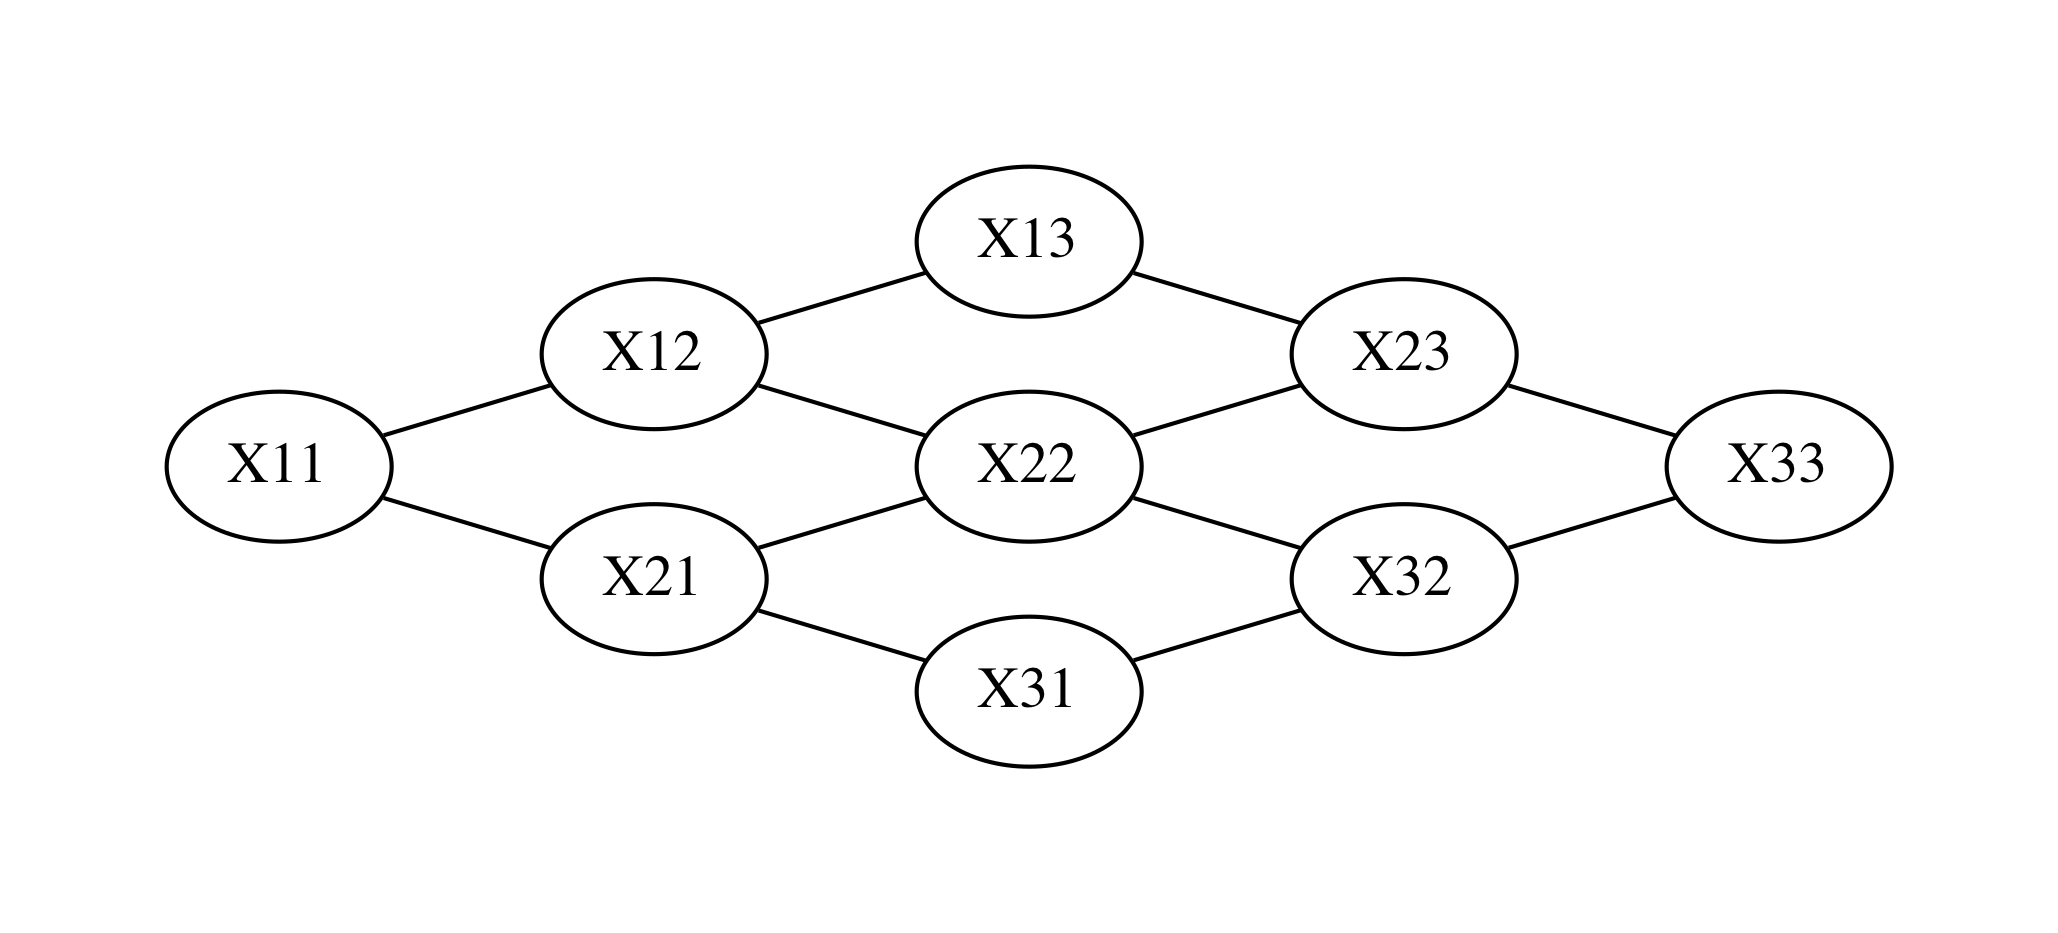

In [37]:
g1 = nx.Graph()

edges = [("X11", "X12"), ("X11", "X21"), ("X12", "X13"), ("X12", "X22"), 
         ("X21", "X22"), ("X21", "X31"), ("X13", "X23"), ("X22", "X32"), ("X22", "X23"), 
         ("X31", "X32"), ("X23", "X33"), ("X32", "X33")]

for edge in edges:
    g1.add_edge(*edge)
    
d1 = to_pydot(g1)
d1.set_dpi(300)
d1.set_margin(0.5)
d1.set_rankdir('LR')
Image(d1.create_png(), width=800)

## 클리크와 팩터

마코프 네트워크는 클리크(clique)로 구성되는데 클리크를 구성하는 확률변수의 분포는 포텐셜 함수(potential function) 또는 팩터(factor)로 표현할 수 있다. 팩터는 가능한 모든 결과의 조합에 대한 실수함수다. 따라서 확률분포함수는 팩터의 일종이다. 하지만 팩터는 확률분포함수와 달리 모든 값을 더해서 1이 되어야 한다는 조건이 없다.

$$p(X, Y) = \dfrac{1}{Z}\psi_1(X, Y)$$

$$p(X | Y) = \dfrac{1}{Z}\psi_2(X, Y)$$

pgmpy는 팩터를 정의하는 DiscreteFactor 클래스를 제공한다.

In [38]:
from pgmpy.factors.discrete import DiscreteFactor

phi = DiscreteFactor(['x1', 'x2', 'x3'], [2, 2, 2], np.arange(8))
print(phi)

+-------+-------+-------+-----------------+
| x1    | x2    | x3    |   phi(x1,x2,x3) |
+=======+=======+=======+=================+
| x1(0) | x2(0) | x3(0) |          0.0000 |
+-------+-------+-------+-----------------+
| x1(0) | x2(0) | x3(1) |          1.0000 |
+-------+-------+-------+-----------------+
| x1(0) | x2(1) | x3(0) |          2.0000 |
+-------+-------+-------+-----------------+
| x1(0) | x2(1) | x3(1) |          3.0000 |
+-------+-------+-------+-----------------+
| x1(1) | x2(0) | x3(0) |          4.0000 |
+-------+-------+-------+-----------------+
| x1(1) | x2(0) | x3(1) |          5.0000 |
+-------+-------+-------+-----------------+
| x1(1) | x2(1) | x3(0) |          6.0000 |
+-------+-------+-------+-----------------+
| x1(1) | x2(1) | x3(1) |          7.0000 |
+-------+-------+-------+-----------------+


pgmpy의 CPD 결합분포 객체는 팩터로 변환하는 to_factor 메서드를 제공한다.

In [39]:
print(P_B_I_A.to_factor())

+------+------+------------+
| B    | A    |   phi(B,A) |
+======+======+============+
| B(0) | A(0) |     0.6000 |
+------+------+------------+
| B(0) | A(1) |     0.2000 |
+------+------+------------+
| B(0) | A(2) |     0.2000 |
+------+------+------------+
| B(1) | A(0) |     0.3000 |
+------+------+------------+
| B(1) | A(1) |     0.5000 |
+------+------+------------+
| B(1) | A(2) |     0.2000 |
+------+------+------------+
| B(2) | A(0) |     0.1000 |
+------+------+------------+
| B(2) | A(1) |     0.3000 |
+------+------+------------+
| B(2) | A(2) |     0.6000 |
+------+------+------------+


factor 객체는 어떤 확률변수가 특정한 값을 가지는 경우만 추출하는 reduce 메서드를 제공한다.

In [40]:
print(P_B_I_A.to_factor().reduce([("B", 0)], inplace=False))

+------+----------+
| A    |   phi(A) |
+======+==========+
| A(0) |   0.6000 |
+------+----------+
| A(1) |   0.2000 |
+------+----------+
| A(2) |   0.2000 |
+------+----------+


In [41]:
print(P_B_I_A.to_factor().reduce([("A", 1)], inplace=False))

+------+----------+
| B    |   phi(B) |
+======+==========+
| B(0) |   0.2000 |
+------+----------+
| B(1) |   0.5000 |
+------+----------+
| B(2) |   0.3000 |
+------+----------+


## 마코프 네트워크의 확률분포

마코프 네트워크의 결합확률분포는 마코프 네트워크를 구성하는 모든 클리크의 팩터의 곱으로 나타난다.

$$P(X) = \dfrac{1}{Z(X)} \prod_{\{C\}} \psi_C(X_C)$$

이 식에서  𝐶 는 클리크,  𝑋_𝐶 는 그 클리크 안의 확률변수,  𝜓_𝐶 는 그 클리크의 팩터,  {𝐶} 는 모든 클리크의 집합,  𝑍 는 파티션 함수(partition)함수를 나타낸다.

예를 들어 3 x 3 이미지의 경우 9개의 확률변수의 결합확률분포는 다음처럼 표현할 수 있다.

$$P(X_{11}, \ldots, X_{33}) = 
\dfrac{1}{Z}
\prod 
\psi(X_{11}, X_{12}) 
\psi(X_{11}, X_{21}) 
\psi(X_{12}, X_{13}) 
\cdots
\psi(X_{23}, X_{33}) 
\psi(X_{32}, X_{33})$$

## 에너지 함수

팩터 함수는 다음과 같은 형태로 표시할 수 있다.

$$\psi(X) = \exp(−E(X))$$

이 식에서  𝐸(𝑋) 를 에너지 함수(energe function)라고 한다. 확률이 높을수록 에너지 함수의 값은 작아진다.

예를 들어 0과 1이라는 값을 가지는 베르누이 확률변수  𝑋1, 𝑋2 가 다음과 같은 에너지 함수로 표현되는 경우,

$$E(X_1, X_2) = -3(2X_1 - 1)(2X_2 - 1)$$

팩터의 값을 구하면

$$\psi(X_1 = 1, X_2 = 1) = e^3$$

$$\psi(X_1 = 0, X_2 = 0) = e^3$$

$$\psi(X_1 = 1, X_2 = 0) = e^{-3}$$

$$\psi(X_1 = 0, X_2 = 1) = e^{-3}$$

즉  𝑋1,𝑋2  둘 다 같은 값을 가질 확률은 서로 다른 값을 가질 확률에 비해 높아진다. 즉 서로 양의 상관관계를 가지게 된다.

pgmpy에서는 MarkovModel 클래스로 마코프 네트워크 모형을 구현한다.

In [42]:
from pgmpy.models import MarkovModel

n = 3
ginfo = []

for i in range(n):
    for j in range(n):
        if j < n - 1:
            v1 = "X{}{}".format(i + 1, (j + 1))
            v2 = "X{}{}".format(i + 1, (j + 2))
            ginfo.append((v1, v2))
        if i < n - 1:
            v1 = "X{}{}".format(i + 1, (j + 1))
            v2 = "X{}{}".format(i + 2, (j + 1))
            ginfo.append((v1, v2))
ginfo

[('X11', 'X12'),
 ('X11', 'X21'),
 ('X12', 'X13'),
 ('X12', 'X22'),
 ('X13', 'X23'),
 ('X21', 'X22'),
 ('X21', 'X31'),
 ('X22', 'X23'),
 ('X22', 'X32'),
 ('X23', 'X33'),
 ('X31', 'X32'),
 ('X32', 'X33')]

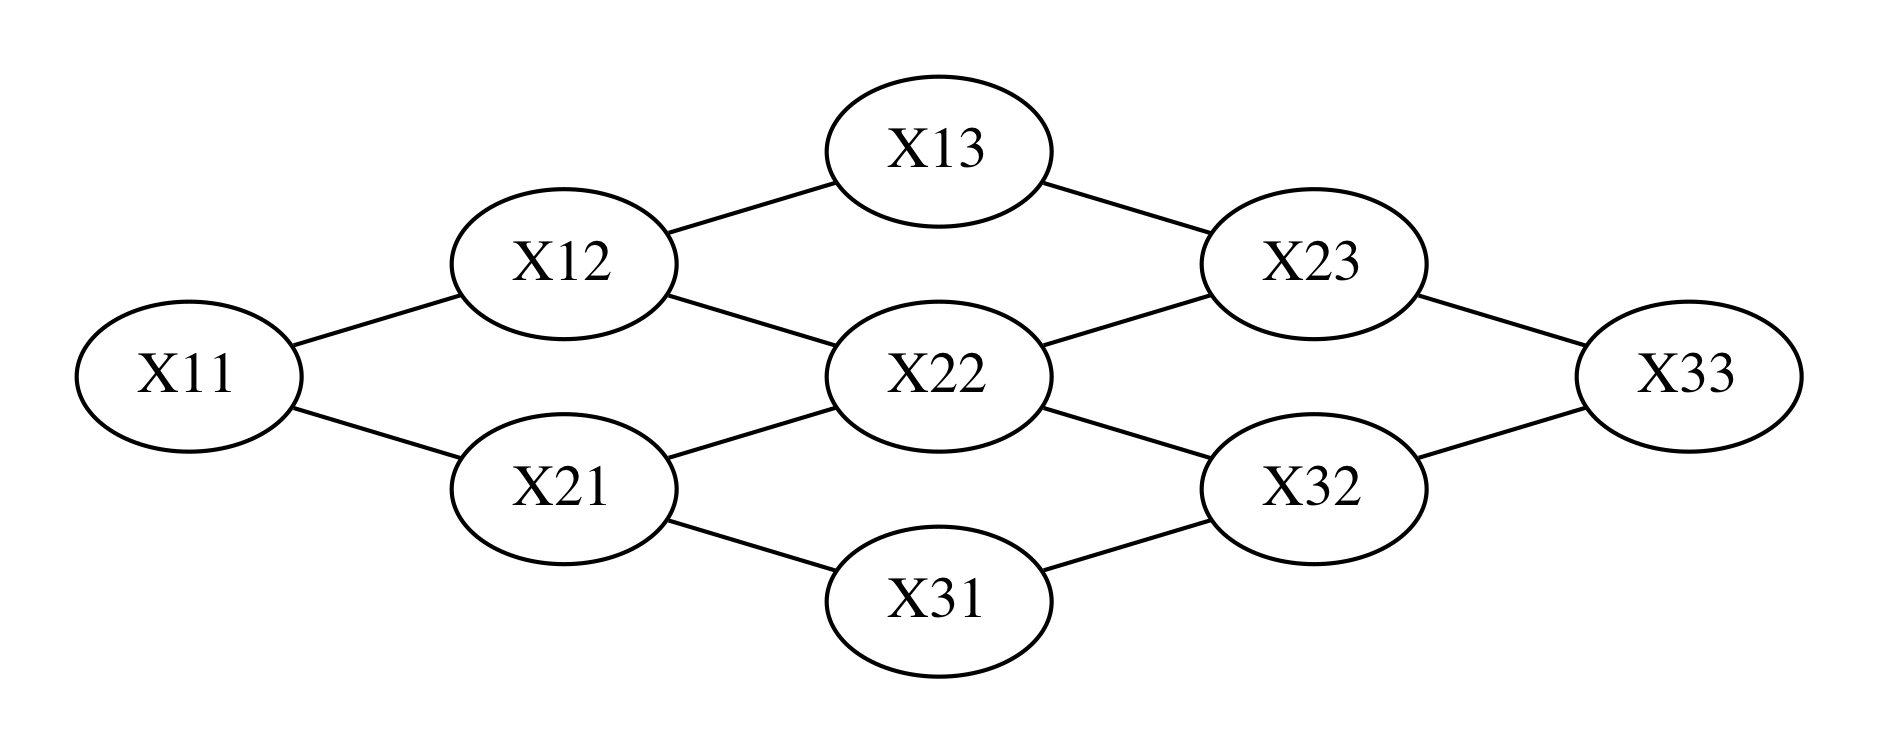

In [43]:
model = MarkovModel(ginfo)

d = to_pydot(model)
d.set_dpi(300)
d.set_margin(0.2)
d.set_rankdir("LR")
Image(d.create_png(), width=600)

팩터는 DiscreteFactor 클래스로 구현할 수 있다. 예를 들어  𝑋11,𝑋12 의 팩터함수가

이면 다음처럼 구현한다.

In [44]:
from pgmpy.factors.discrete import DiscreteFactor

factor = DiscreteFactor(["X11", "X12"], cardinality=[2, 2], values=[[10, 1], [1, 10]])
model.add_factors(factor)

## 이미지 완성

마코프 네트워크의 예로 다음과 같은 두 종류의 5x5 이미지 데이터를 생각하자.

In [46]:
n_char = 2
images = np.zeros((n_char, 5, 5))
idx = []
idx.append(np.array([
    (0, 1), (0, 2), (0, 3), (1, 0), (1, 4), (2, 0), (2, 2), (2, 4), (3, 0), (3, 4), (4, 1), (4, 2), (4, 3), 
]))
idx.append(np.array([
    (0, 0), (0, 4), (1, 1), (1, 3), (2, 2), (3, 1), (3, 3), (4, 0), (4, 4),
]))

idx

[array([[0, 1],
        [0, 2],
        [0, 3],
        [1, 0],
        [1, 4],
        [2, 0],
        [2, 2],
        [2, 4],
        [3, 0],
        [3, 4],
        [4, 1],
        [4, 2],
        [4, 3]]), array([[0, 0],
        [0, 4],
        [1, 1],
        [1, 3],
        [2, 2],
        [3, 1],
        [3, 3],
        [4, 0],
        [4, 4]])]

In [47]:
for k, idx in enumerate(idx):
    for i, j in idx:
        images[k, i, j] = 1
images

array([[[0., 1., 1., 1., 0.],
        [1., 0., 0., 0., 1.],
        [1., 0., 1., 0., 1.],
        [1., 0., 0., 0., 1.],
        [0., 1., 1., 1., 0.]],

       [[1., 0., 0., 0., 1.],
        [0., 1., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 1., 0.],
        [1., 0., 0., 0., 1.]]])

In [49]:
import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.pylab as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 12

path = "/Library/Fonts/NanumGothic.otf"
font_name = fm.FontProperties(fname=path, size=20).get_name()

plt.rc('font', family=font_name)

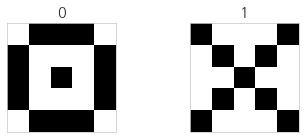

In [50]:
plt.figure(figsize=(6, 2))
for i in range(n_char):
    plt.subplot(1, n_char, i+1)
    plt.imshow(images[i], cmap=plt.cm.bone_r)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.title(i)

다음과 같이 팩터 함수를 학습한다.

In [51]:
from pgmpy.models import MarkovModel
from pgmpy.factors.discrete import DiscreteFactor

In [52]:
def get_factor(v1, v2, idx1, idx2):
    p00 = p01 = p10 = p11 = 0
    for k in range(num_images):
        if images[k, idx1[0], idx1[1]] == 0 and images[k, idx2[0], idx2[1]] == 0:
            p00 += 1
        if images[k, idx1[0], idx1[1]] == 0 and images[k, idx2[0], idx2[1]] == 1:
            p01 += 1
        if images[k, idx1[0], idx1[1]] == 1 and images[k, idx2[0], idx2[1]] == 0:
            p10 += 1
        if images[k, idx1[0], idx1[1]] == 1 and images[k, idx2[0], idx2[1]] == 1:
            p11 += 1
    factor = DiscreteFactor([v1, v2], cardinality=[2, 2], values=[[p00, p01], [p10, p11]])
    return factor

model = MarkovModel()

In [53]:
num_images = images.shape[0]
num_images

2

In [54]:
n1 = images.shape[1]
n2 = images.shape[2]
for i in range(n1):
    for j in range(n2):
        if j < n2 - 1:
            v1 = "X{}{}".format(i + 1, (j + 1))
            v2 = "X{}{}".format(i + 1, (j + 2))
            model.add_edge(v1, v2)
            factor = get_factor(v1, v2, (i, j), (i, j+1))
            model.add_factors(factor)
        if i < n1 - 1:
            v1 = "X{}{}".format(i + 1, (j + 1))
            v2 = "X{}{}".format(i + 2, (j + 1))
            model.add_edge(v1, v2)
            factor = get_factor(v1, v2, (i, j), (i+1, j))
            model.add_factors(factor)
model.check_model()

True

학습된 팩터의 일부를 살펴보자. 일례로  𝑋11 과  𝑋12 의 결합확률 팩터는 다음과 같다.

In [55]:
f = model.get_factors("X11")[0]
f

<DiscreteFactor representing phi(X11:2, X12:2) at 0x1a261e0748>

In [56]:
print(f)

+--------+--------+----------------+
| X11    | X12    |   phi(X11,X12) |
+========+========+================+
| X11(0) | X12(0) |         0.0000 |
+--------+--------+----------------+
| X11(0) | X12(1) |         1.0000 |
+--------+--------+----------------+
| X11(1) | X12(0) |         1.0000 |
+--------+--------+----------------+
| X11(1) | X12(1) |         0.0000 |
+--------+--------+----------------+


다음은 전체 네트워크 모양이다.

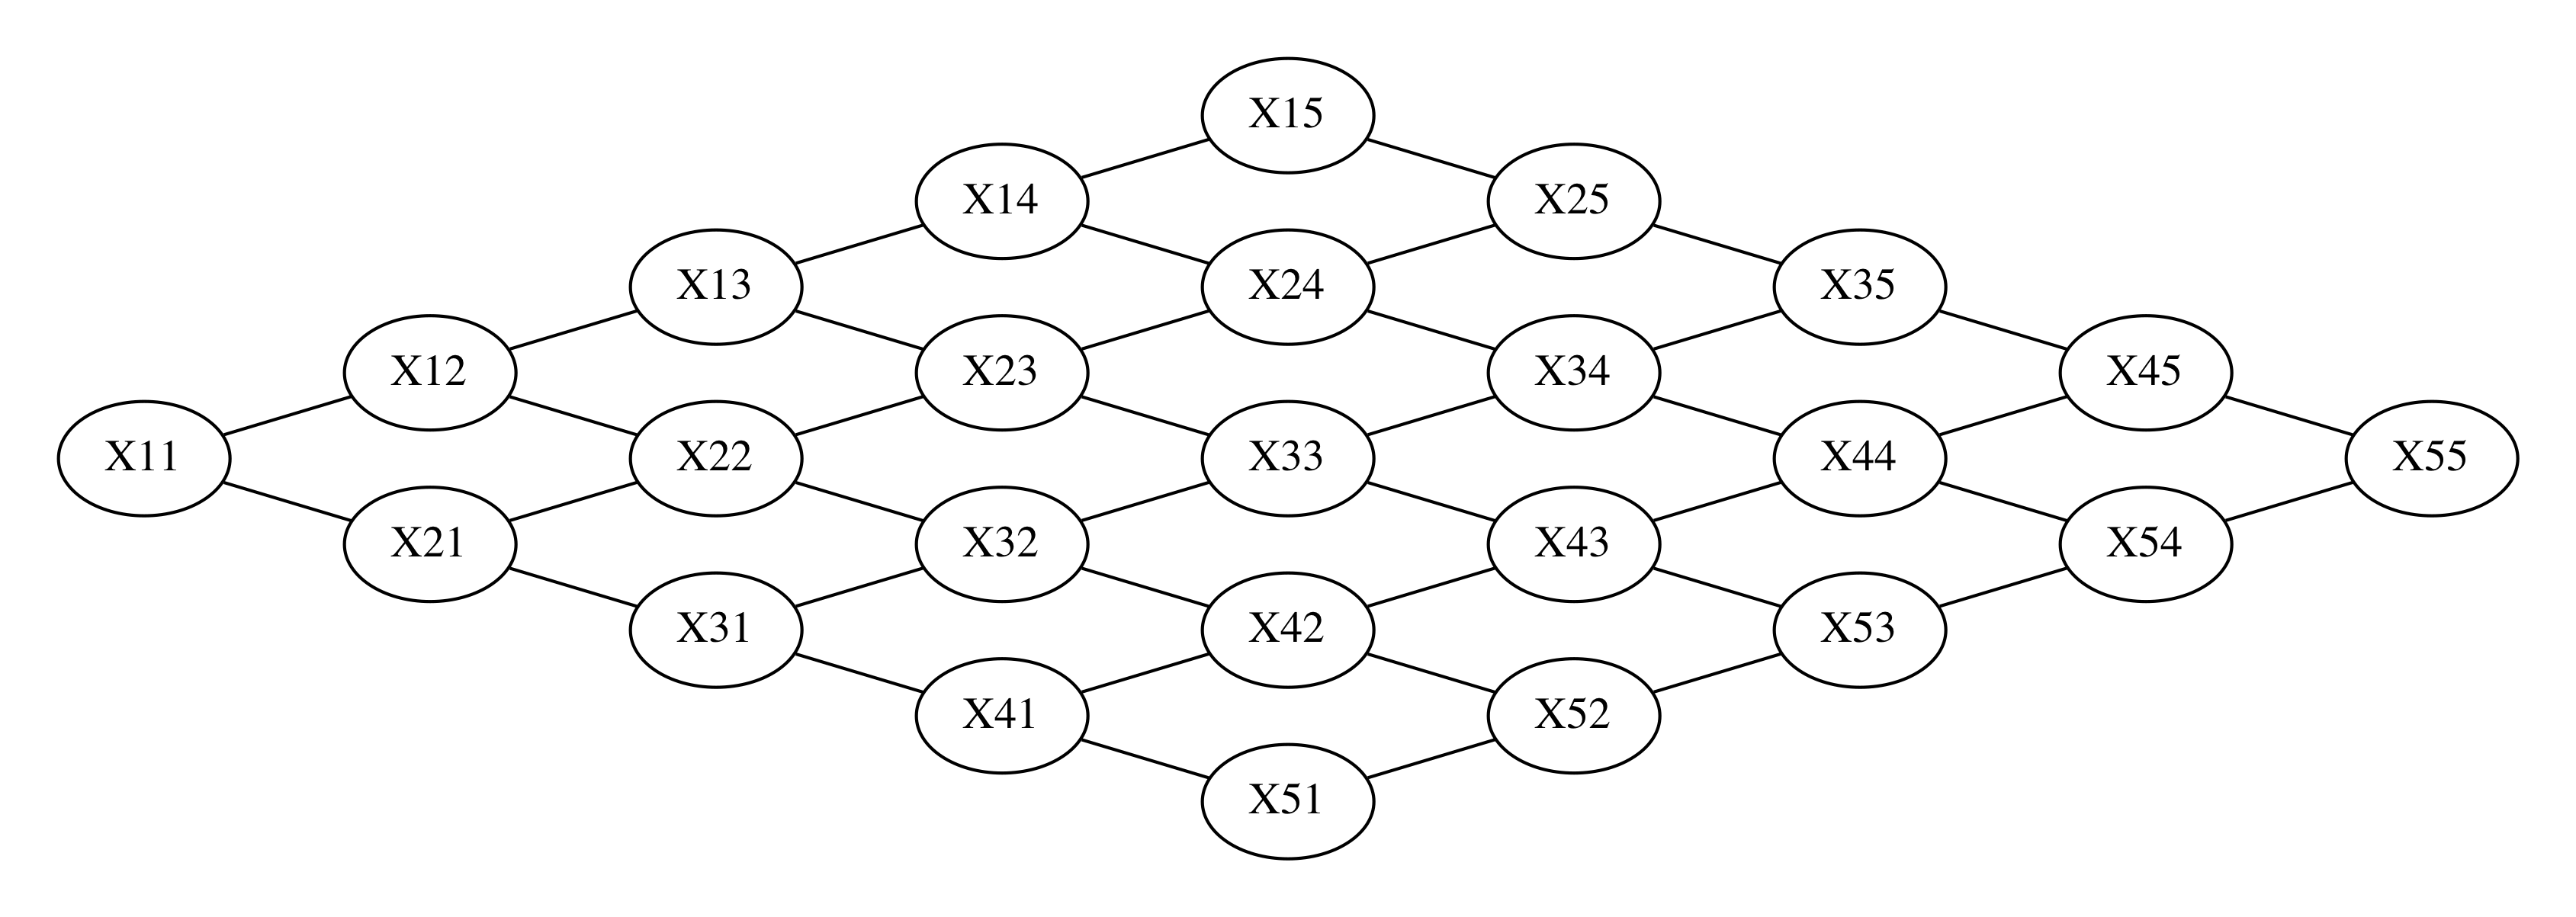

In [57]:
d = to_pydot(model)
d.set_dpi(300)
d.set_margin(0.2)
d.set_rankdir('LR')
Image(d.create_png(), width=600)

다음 코드는 이미지의 일부를 알고 있을 때 나머지 이미지를 추정한 결과이다. 코드에서 evidence는 관측된 이미지의 일부이다. 여기에서 사용하는 BeliefPropagation 클래스는 다음 절에서 공부한다.

In [58]:
from pgmpy.inference import BeliefPropagation
inference = BeliefPropagation(model)

In [59]:
vars = []
for i in range(n1):
    for j in range(n2):
        vars.append("X{}{}".format(i + 1, j + 1))
evidence1 = {
    "X11": 0, "X21": 1, "X31": 1, "X41": 1, "X51": 0,
    "X15": 0, "X25": 1, "X35": 1, "X45": 1, "X55": 0,
}
evidence2 = {
    "X11": 1, "X21": 0, "X31": 0, "X41": 0, "X51": 1,
    "X15": 1, "X25": 0, "X35": 0, "X45": 0, "X55": 1,
}

evidence = evidence1

for x in evidence:
    vars.remove(x)  # vars에서 evidence1을 제거
vars

['X12',
 'X13',
 'X14',
 'X22',
 'X23',
 'X24',
 'X32',
 'X33',
 'X34',
 'X42',
 'X43',
 'X44',
 'X52',
 'X53',
 'X54']

In [62]:
result = inference.map_query(variables=vars, evidence=evidence)
result.update(evidence)

image = np.zeros((n1, n2))  # 5, 5
for i in range(n1):
    for j in range(n2):
        image[i, j] = result["X{}{}".format(i+1, j+1)]
print(image)

0it [00:00, ?it/s]

[[0. 1. 1. 1. 0.]
 [1. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1.]
 [1. 0. 0. 0. 1.]
 [0. 1. 1. 1. 0.]]


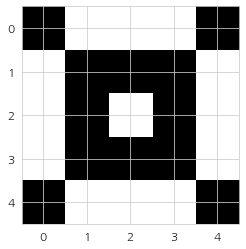

In [63]:
plt.imshow(image, cmap=plt.cm.bone)
plt.show()